# Autoregressive HMM on example session

In [78]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files, prepro_design_matrix, concatenate_sessions
from fitting_functions import cross_validate_armodel, compute_inputs
from plotting_functions import plot_transition_mat, plot_states_aligned, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates, traces_over_few_sates

one = ONE()

## Parameters

In [79]:
bin_size = 0.1

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'


## Data paths

In [80]:
data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
data_path_v3 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v3_1Jul2024/' + str(bin_size) + '/'
data_path_v4 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v4_5Jul2024/' + str(bin_size) + '/'

data_path = data_path_v4

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
       # var_names = ['avg_wheel_vel', 'whisker_me']
       var_names = ['avg_wheel_vel']
elif data_path == data_path_v3:
       var_names = [ 'wheel_final', 'Lick count', 'pupil_diameter', 'whisker_me',
       'left_X', 'left_Y', 'pupil_X', 'pupil_Y', 'nose_X', 'nose_Y']
       var_names = ['Lick count']
elif data_path == data_path_v4:
       var_names = ['left_X', 'left_Y', 'right_X', 'right_Y']
       var_names = ['right_X', 'right_Y']
       var_names = ['avg_wheel_vel']
       
# Load frame rate
fr_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/frame_rate/'
os.chdir(fr_path)
frame_rate = pickle.load(open(fr_path + "frame_rate", "rb"))


## Preprocess list of design matrices

- Each session is saved under the mouse name; concatenated with other sessions of the same mouse;
- Only data up to trial 90 is kept;
- Data is normalized and standardized

In [81]:
idxs, mouse_names = idxs_from_files(one, design_matrices, frame_rate, data_path, bin_size)
matrix_all, matrix_all_unnorm, session_all = prepro_design_matrix(one, idxs, mouse_names, 
                                                                  bin_size, var_names, data_path, first_90=True)

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 13.3kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 14.4kB/s]
local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 13.3kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger

IndexError: index 1 is out of bounds for axis 1 with size 1

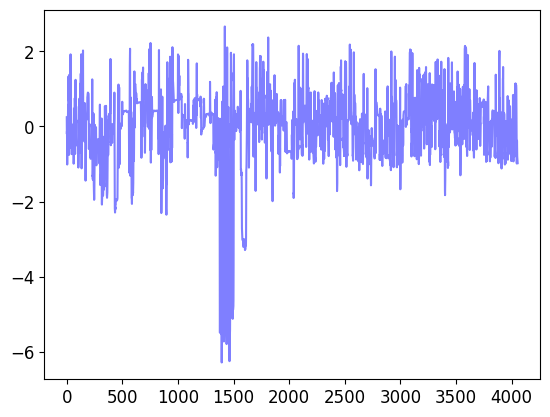

In [49]:
for m, mat in enumerate(idxs[0:1]):
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'CSHL060'
        session = mat[0:36]
        
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
        
        plt.plot(design_matrix[:, 0], alpha=0.5, color='blue', label='Left X')
        plt.plot(design_matrix[:, 1], alpha=0.5, color='blue', linestyle='--', label='Left Y')
        
        # plt.plot(design_matrix[:, 2], alpha=0.5, color='orange', label='Right X')
        # plt.plot(design_matrix[:, 3], alpha=0.5, color='orange', linestyle='--', label='Right Y')

        print(mat)
        plt.ylabel('Nose position')
        plt.xlim([50, 100])
        plt.title(mat)
        plt.legend()
        plt.show()



## Concatenate sessions of the same animal

In [ ]:
collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

## Parameters

In [82]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
threshold = 0.05

num_lags = 11  # First order ARHMM
num_states = 2
kappa = 1000

# Plotting params
bin_size = 0.1

1


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


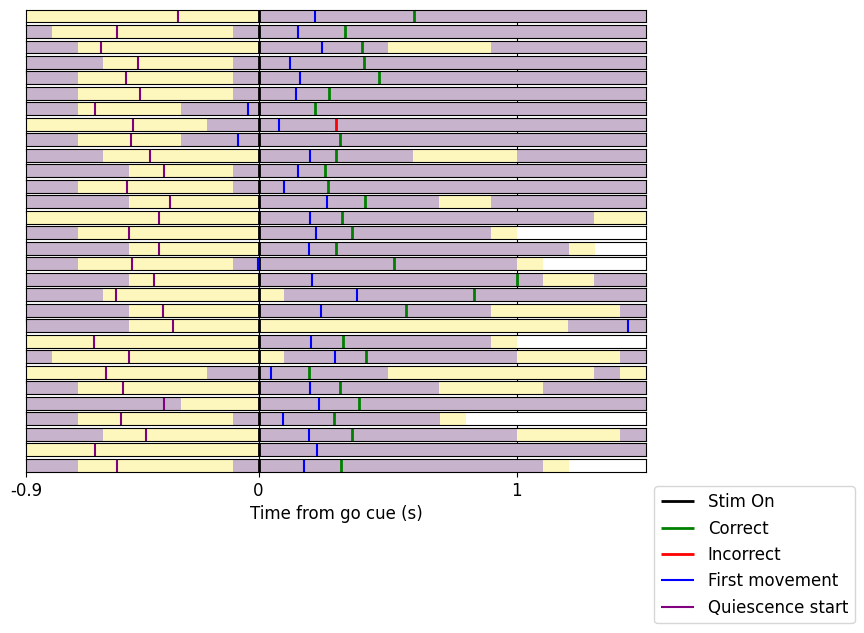

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:650: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  axs.imshow(use_normalized['most_likely_states'][None,:],


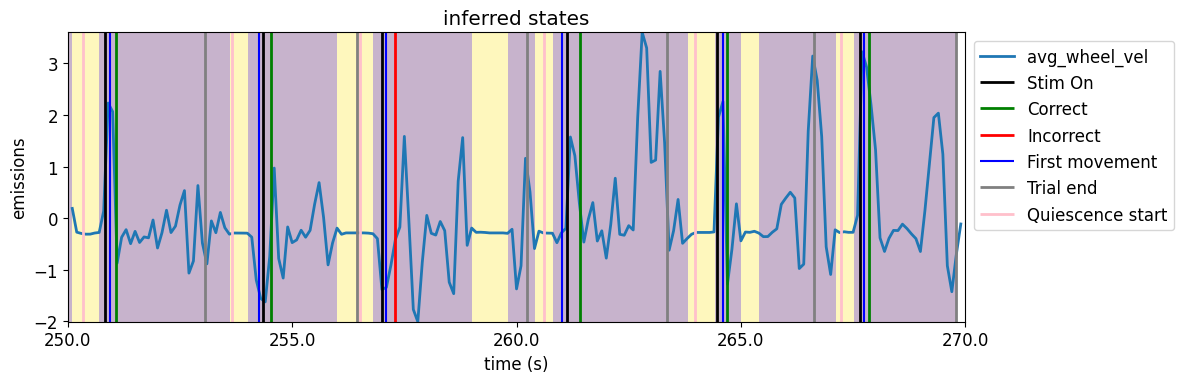

In [96]:
for m, mat in enumerate(idxs[0:1]):
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'CSHL060'
        session = mat[0:36]
        
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
        " Fit model with cross-validation"
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        # Initialize model with Kmeans
        test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
        init_params, props = test_arhmm.initialize(key=jr.PRNGKey(1), method=method, emissions=shortened_array)  # for now all data
        
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
        # Fit model to all data with cross-validation
        val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, 
                                                                              jr.PRNGKey(0), shortened_array, train_emissions, train_inputs, method, num_train_batches)


        " Re-fit with parameters of best fold "
        # Find best fold
        use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
        print(use_fold)
        
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_weights = fit_params[2].weights[use_fold]
        emission_biases = fit_params[2].biases[use_fold]
        emission_covariances = fit_params[2].covs[use_fold]        
        
        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases, 
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include  
        
        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

        # Keep only enough states to explain 95% observations
        
        unique, counts = np.unique(most_likely_states, return_counts=True)
        threshold_count = threshold * len(most_likely_states)
        excluded_bins = 0
        remaining_states = list(counts.copy())
        for state in unique:
            size_smallest_state = np.nanmin(remaining_states)
            if size_smallest_state + excluded_bins < threshold_count:
                remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                excluded_bins += size_smallest_state
        
        # Remove states below threshold
        new_states = np.array(most_likely_states).astype(float)
        exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
        # Create a boolean mask to identify values to replace
        mask = np.isin(new_states, exclude_states)
        # Replace values in main_array with np.nan using the boolean mask
        new_states[mask] = np.nan

        new_states = most_likely_states
        
        " Plots "
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        init = -10
        end = 15
        empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)

    
        """ Stack trial states """
        trial_init = 30  # First trial to plot
        trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
        plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)

        # " Plot states stacked and aligned per trial type "
        # plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
        
        # """ Plot states per trial epoch """
        # colors = sns.color_palette("viridis", num_states)
        # states_trial = states_per_trial_phase(empirical_data, session_trials)
        # plt.figure(figsize=[7, 5])
        # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
        #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
        # plt.xlabel('Trial phase')
        # plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
        # plt.xticks(rotation=45)
        # plt.tight_layout()
        # plt.title(mouse_name)
        # plt.show()
    
        """ Plot raw traces over states """
        init = 2500 # First bin
        inter = 200
        # traces_over_few_sates(init, empirical_data, session_trials, var_names)
        traces_over_few_sates(init, inter, empirical_data, session_trials, var_names)


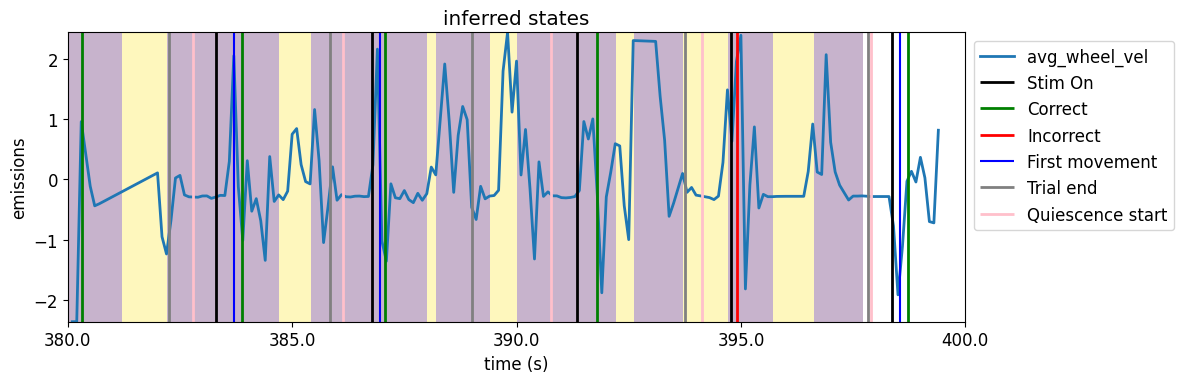

In [94]:
""" Plot raw traces over states """
init = 3800 # First bin
inter = 200
traces_over_few_sates(init, inter, empirical_data, session_trials, var_names)

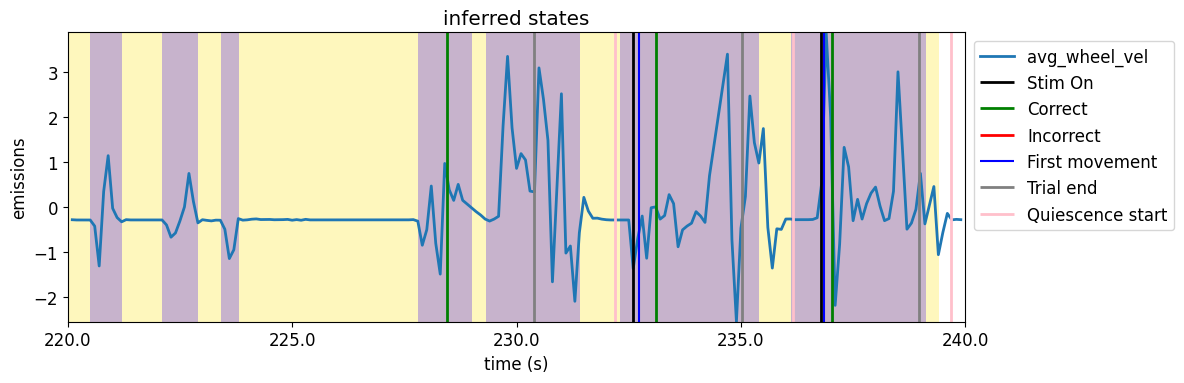

In [95]:
""" Plot raw traces over states """
init = 2200 # First bin
inter = 200
traces_over_few_sates(init, inter, empirical_data, session_trials, var_names)

# From dynamax notebook

In [23]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# Make a transition matrix
num_states = 5
transition_probs = (jnp.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = jnp.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += jnp.roll(p * jnp.eye(num_states), k, axis=1)


# Make observation distributions
emission_dim = 2
num_lags = 1

keys = jr.split(jr.PRNGKey(0), num_states)
angles = jnp.linspace(0, 2 * jnp.pi, num_states, endpoint=False)
theta = jnp.pi / 25 # rotational frequency
weights = jnp.array([0.8 * random_rotation(key, emission_dim, theta=theta) for key in keys])
biases = jnp.column_stack([jnp.cos(angles), jnp.sin(angles), jnp.zeros((num_states, emission_dim - 2))])
covariances = jnp.tile(0.001 * jnp.eye(emission_dim), (num_states, 1, 1))

# Compute the stationary points
stationary_points = jnp.linalg.solve(jnp.eye(emission_dim) - weights, biases)

if emission_dim == 2:
    lim = 5
    x = jnp.linspace(-lim, lim, 10)
    y = jnp.linspace(-lim, lim, 10)
    X, Y = jnp.meshgrid(x, y)
    xy = jnp.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k in range(num_states):
        A, b = weights[k], biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('$x_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("$x_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
                        

    plt.tight_layout()
    
# Make an Autoregressive (AR) HMM
true_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
true_params, _ = true_arhmm.initialize(initial_probs=jnp.ones(num_states) / num_states,
                                       transition_matrix=transition_matrix,
                                       emission_weights=weights,
                                       emission_biases=biases,
                                       emission_covariances=covariances)

time_bins = 10000
true_states, emissions = true_arhmm.sample(true_params, jr.PRNGKey(0), time_bins)

# Compute the lagged emissions (aka inputs)
inputs = true_arhmm.compute_inputs(emissions)


# Plot the sampled data
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*emissions[true_states==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*emissions[:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")


In [8]:

" Prepare data for cross-validation "
num_timesteps = np.shape(matrix_all[ses][0])[0]
emission_dim = np.shape(matrix_all[ses][0])[1]
shortened_array = np.array(matrix_all[ses][0][:(num_timesteps // num_train_batches) * num_train_batches])
train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

" Initialize model with Kmeans "
test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags)
params, props = test_arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=shortened_array)  # for now all data
my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)

" Fit model to all data "

# Fit with EM
fitted_params, lps = test_arhmm.fit_em(params, props, shortened_array, inputs=my_inputs)  #, inputs=inputs


# val_lls, fit_params, init_params, baseline_lls, train_lls = cross_validate_model(test_arhmm, jr.PRNGKey(0), shortened_array, train_emissions, 'kmeans', num_train_batches)

# " Find best fold (this is what Zoe does) results "
# use_fold = np.where(val_lls==np.max(val_lls))[0][0]
# print(use_fold)
    
# # Find parameters for best fold
# initial_probs = fit_params[0].probs[use_fold]
# transition_matrix = fit_params[1].transition_matrix[use_fold]
# emission_means = fit_params[2].means[use_fold]
# emission_covs = fit_params[2].covs[use_fold]
    
# # Initialize new hmm
# new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
# best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method=method, initial_probs=initial_probs,
#                                 transition_matrix=transition_matrix,
#                                 emission_means=emission_means,
#                                 emission_covariances=emission_covs,
#                                 emissions=matrix_all[ses][0])  # not sure if I need to include  

# # Get state estimates for validation data
# most_likely_states = new_hmm.most_likely_states(best_fold_params, matrix_all[ses][0])
    

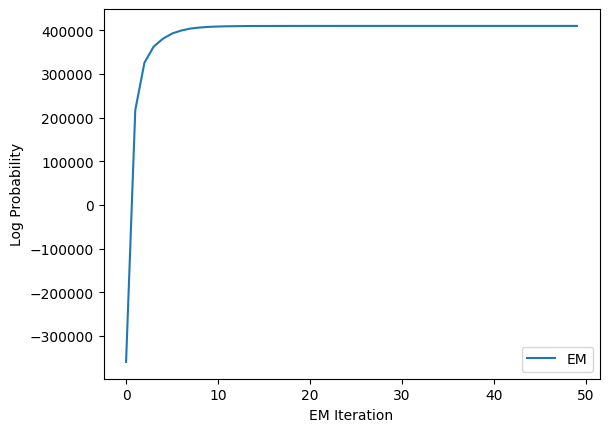

In [9]:
# true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
# plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [10]:
posterior = test_arhmm.smoother(fitted_params, shortened_array, inputs=my_inputs)
most_likely_states = test_arhmm.most_likely_states(fitted_params, shortened_array, inputs=my_inputs)


In [11]:
if emission_dim == 2:
    lim = 10
    x = jnp.linspace(-lim, lim, 10)
    y = jnp.linspace(-lim, lim, 10)
    X, Y = jnp.meshgrid(x, y)
    xy = jnp.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k in range(num_states):
        A, b = weights[k], biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('Wheel speed')
        #axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("Pupil diameter")
        
        #axs[k].set_yticks([])
        axs[k].set_aspect("equal")
        axs[k].set_title(str('State ' + str(k+1)))
                        

    plt.tight_layout()

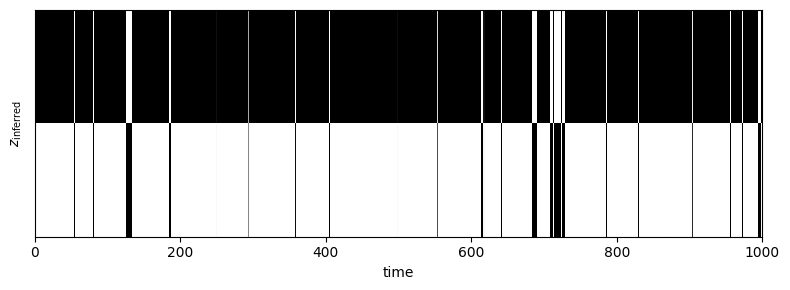

In [12]:
plot_slice = (0, 1000)
plt.figure(figsize=(8, 3))

plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [13]:
posterior.smoothed_probs.T

Array([[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 8.2264848e-13,
        9.5391240e-13, 2.2208334e-11],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00]], dtype=float32)

In [15]:
len(posterior.smoothed_probs.T[0])

33740

In [16]:
len(shortened_array)

33740

In [ ]:
    """
    bins = np.arange(0, 100, 1)
    plt.hist(most_likely_states, bins)
    plt.xlabel('State')
    plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
    plt.ylabel('Number of bins')
    plt.title(ses)
    plt.show()
    """
    
    """ Plot states per trial type, aligned on events """
    #test_set = test_all[ses][0]
    init = -10
    end = 15
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix, most_likely_states, multiplier)
                                            
    plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
    
    """ Plot fit parameters """
    #states = ('State 0', "State 1", "State 2", 'State 3') 
    #states = ('State 0', 'State 1', 'State 2')
    states = []
    for s in range(num_states):
        state = 'State ' + str(s)
        states.append(state)
    
    # fig, ax = plt.subplots(ncols=len(states) , nrows=1, sharex=True, sharey=True, figsize=[20, 5])
    # plt.rc('font', size=12)

    # learned_params = params_to_df (var_names, len(states), num_train_batches, fit_params, norm_results=False)
    # for s, state in enumerate(states):
    #     use_data = learned_params.loc[learned_params['state']==s]
    #     sns.barplot(y='variable', x='value', data=use_data, ax=ax[s], palette='plasma')
    #     ax[s].vlines(0, -.50, 9.5, color='Gray', linestyles='--', linewidth=1)
    #     ax[s].set_xlabel('Mean')
    #     #ax[s].set_title(state)

    # plt.tight_layout()
    # plt.title(ses)
    # plt.show()

    """ Plot states per trial phase """
    colors = sns.color_palette("viridis", num_states)
    states_trial = states_per_trial_phase(empirical_data, session_trials)
    plt.figure(figsize=[7, 5])
    sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                        multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
    plt.xlabel('Trial phase')
    plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(ses)
    plt.show()
    

    """ Stack trial states """
    trial_init = 100  # First trial to plot
    trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
    plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)
    

    """ Plot raw traces over states """
    init = 6000  # First bin
    traces_over_sates(init, design_matrix, most_likely_states, session_trials, var_names)

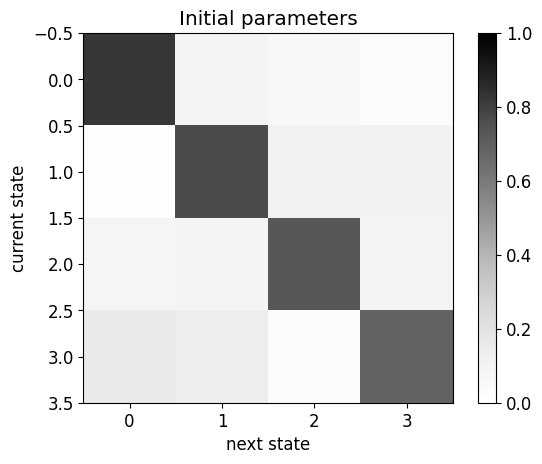

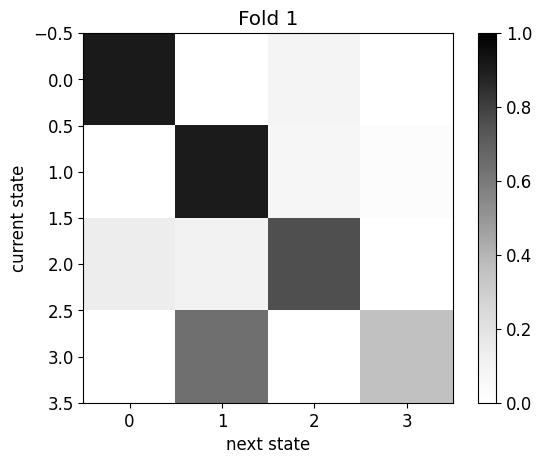

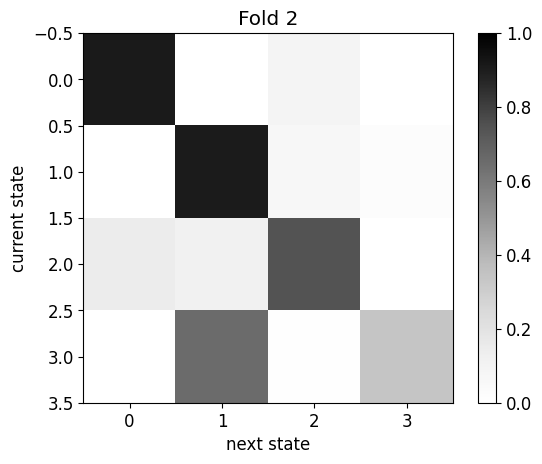

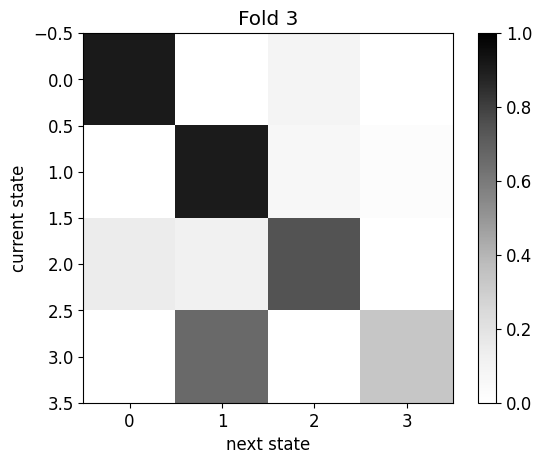

Array([[9.0734458e-01, 7.1028230e-04, 9.1937467e-02, 7.7039131e-06],
       [7.6419001e-06, 9.0575910e-01, 6.8851024e-02, 2.5382234e-02],
       [1.4591575e-01, 1.1145600e-01, 7.4253851e-01, 8.9726505e-05],
       [1.9322814e-04, 6.6256666e-01, 2.5056661e-03, 3.3473444e-01]],      dtype=float32)

In [157]:
plot_transition_mat (init_params, fit_params)

/tmp/ipykernel_46544/3566805684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


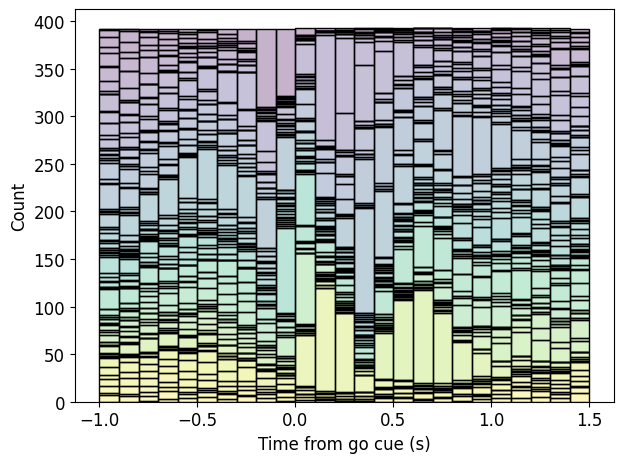

In [10]:
    # PLOT
    plt.rc('font', size=12)
    use_data = empirical_data.dropna()
    use_data['new_bin'] = use_data['new_bin'] * bin_size
    
    sns.histplot(x='new_bin', hue='most_likely_states', data=use_data, stat='count', alpha=0.3, 
                    multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, palette='viridis')

    ax.set_xlabel(str('Time from go cue (s)'))
    plt.xlabel('Time from go cue (s)')

    plt.tight_layout()
    plt.show()

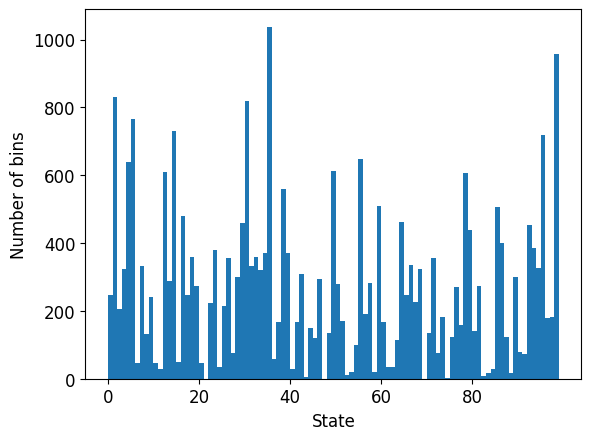

In [14]:
# TODO: order states
# Plot histogram
bins = np.arange(0, num_states, 1)
plt.hist(most_likely_states, bins)
plt.xlabel('State')
plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
plt.ylabel('Number of bins')
plt.xticks(np.arange(0, 100, 20), np.arange(0, 100, 20))
#plt.title(ses)
plt.show()

### Reduce states to represent

In [8]:
counts, _ = np.histogram(most_likely_states, bins=num_states)

In [9]:
session_length = np.sum(counts)
session_length

threshold_bins = 0.95*session_length  # minimum number of bins that the state appeared in (100 corresponds to 10 seconds on the total session)
threshold = np.ceil(session_length - threshold_bins)

threshold = 150

In [10]:
np.sum(counts>threshold)

60

In [11]:
np.sum(counts[counts>threshold])/np.sum(counts)

0.8882374906646752

In [13]:
_, remove_states = np.where([counts<threshold])

# Create a mask for values in array A that are in array B
mask = np.isin(most_likely_states, remove_states)

# Replace matching values in array A with NaN
new_states = np.array(most_likely_states, dtype=float)
new_states[mask] = np.nan


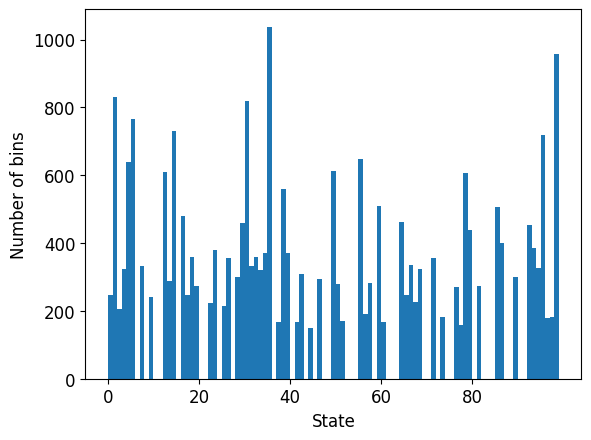

In [22]:
# Plot histogram
bins = np.arange(0, num_states, 1)
plt.hist(new_states, bins)
plt.xlabel('State')
plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
plt.ylabel('Number of bins')
plt.xticks(np.arange(0, 100, 20), np.arange(0, 100, 20))
#plt.title(ses)
plt.show()

## Plot without removed states

In [6]:
# Fit model for optimal number of states

for s, ses in enumerate(design_matrices[0:2]):
    #ses = 'design_matrix_d23a44ef-1402-4ed7-97f5-47e9a7a504d9_0.1'
    session_trials = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))
    
    # Trials data
    session = design_matrices[s][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(ses, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin']<session_end*10) & (design_matrix['Bin']>session_start*10)]
    
    " Fit model "
    # Fit again (TODO: should save these results from the code above)
    num_timesteps = np.shape(matrix_all[ses][0])[0]
    emission_dim = np.shape(matrix_all[ses][0])[1]
    shortened_array = np.array(matrix_all[ses][0][:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
   
    test_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    val_lls, fit_params, init_params, baseline_lls, train_lls = cross_validate_model(test_hmm, jr.PRNGKey(0), shortened_array, train_emissions, 'kmeans', num_train_batches)

    " Find best fold (this is what Zoe does) results "
    use_fold = np.where(val_lls==np.max(val_lls))[0][0]
    print(use_fold)
        
    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    emission_means = fit_params[2].means[use_fold]
    emission_covs = fit_params[2].covs[use_fold]
        
    # Initialize new hmm
    new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="prior", initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,
                                    emission_means=emission_means,
                                    emission_covariances=emission_covs,
                                    emissions=matrix_all[ses][0])  # not sure if I need to include  

    # Get state estimates for validation data
    most_likely_states = new_hmm.most_likely_states(best_fold_params, matrix_all[ses][0])

Fitting session 8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3
Fitting session 9b5a1754-ac99-4d53-97d3-35c2f6638507


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


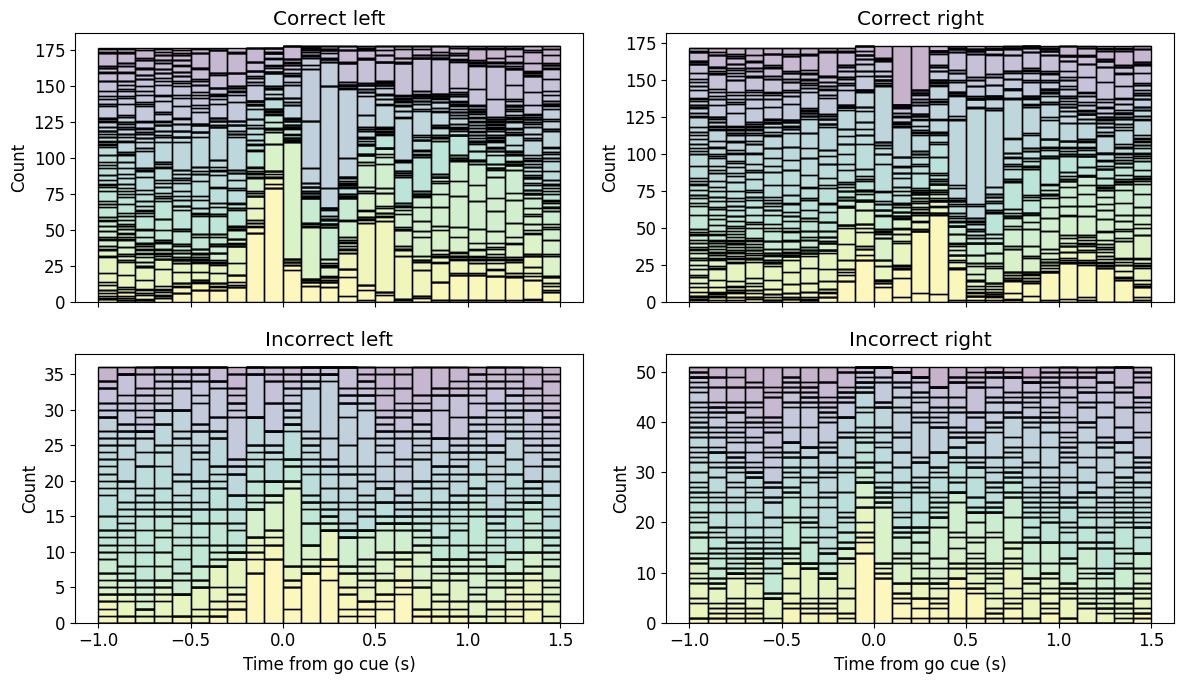

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:394: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:395: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:396: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:397: FutureWarning: Th

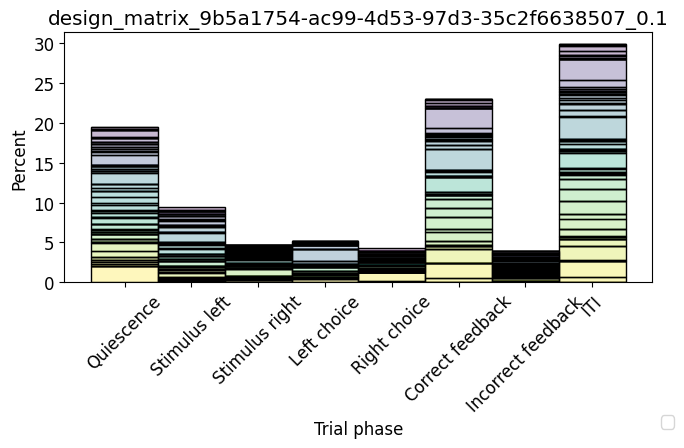

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:412: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


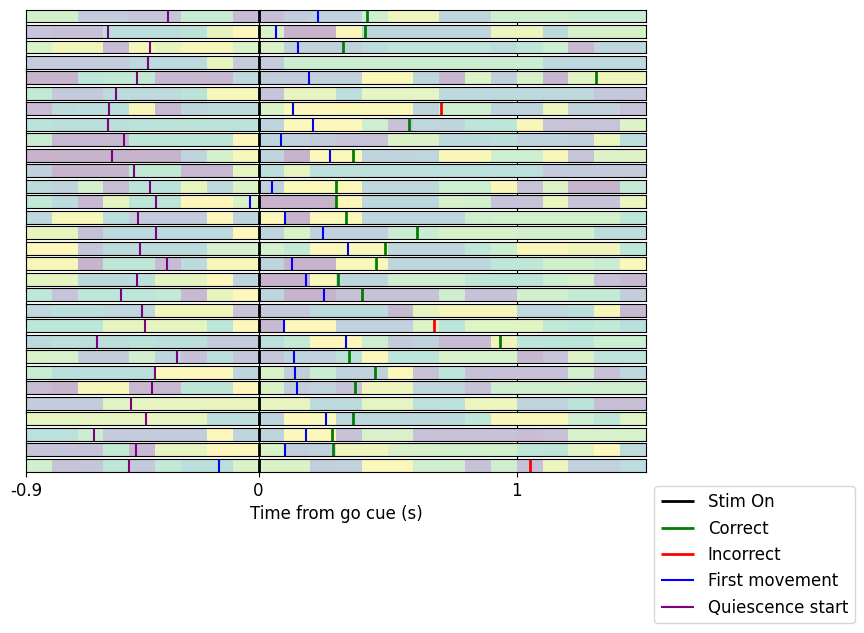

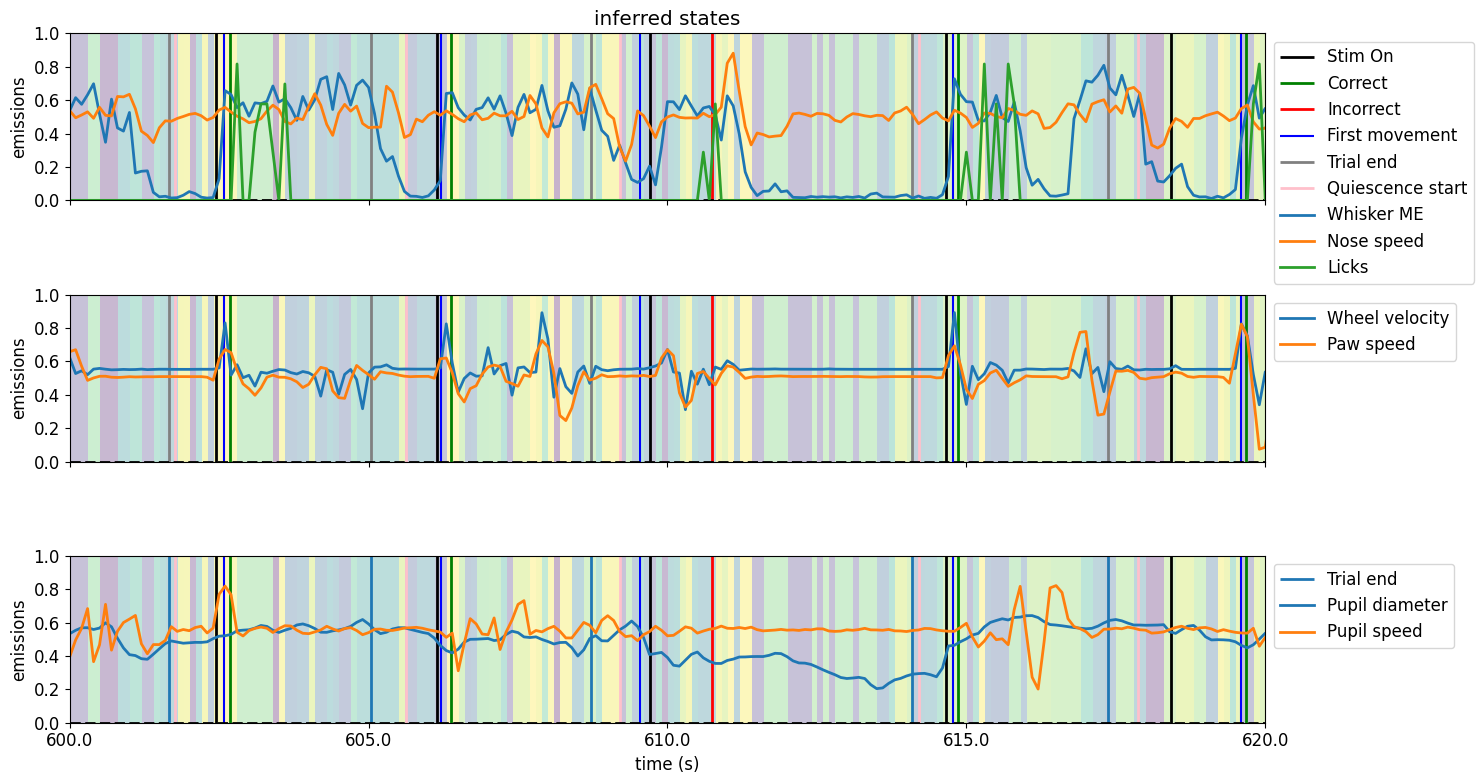

In [15]:
    """ Plot states per trial type, aligned on events """
    #test_set = test_all[ses][0]
    init = -10
    end = 15
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix, most_likely_states, multiplier)
                                            
    plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
    
    """ Plot fit parameters """
    #states = ('State 0', "State 1", "State 2", 'State 3') 
    #states = ('State 0', 'State 1', 'State 2')
    states = []
    for s in range(num_states):
        state = 'State ' + str(s)
        states.append(state)
    
    # fig, ax = plt.subplots(ncols=len(states) , nrows=1, sharex=True, sharey=True, figsize=[20, 5])
    # plt.rc('font', size=12)

    # learned_params = params_to_df (var_names, len(states), num_train_batches, fit_params, norm_results=False)
    # for s, state in enumerate(states):
    #     use_data = learned_params.loc[learned_params['state']==s]
    #     sns.barplot(y='variable', x='value', data=use_data, ax=ax[s], palette='plasma')
    #     ax[s].vlines(0, -.50, 9.5, color='Gray', linestyles='--', linewidth=1)
    #     ax[s].set_xlabel('Mean')
    #     #ax[s].set_title(state)

    # plt.tight_layout()
    # plt.title(ses)
    # plt.show()

    """ Plot states per trial phase """
    colors = sns.color_palette("viridis", num_states)
    states_trial = states_per_trial_phase(empirical_data, session_trials)
    plt.figure(figsize=[7, 5])
    sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                        multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
    plt.xlabel('Trial phase')
    plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(ses)
    plt.show()
    

    """ Stack trial states """
    trial_init = 100  # First trial to plot
    trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
    plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)
    

    """ Plot raw traces over states """
    init = 6000  # First bin
    traces_over_sates(init, design_matrix, most_likely_states, session_trials, var_names)

/tmp/ipykernel_46544/3566805684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


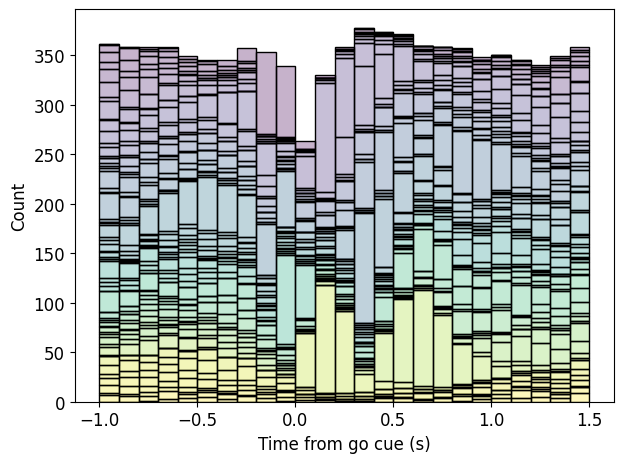

In [24]:
    # PLOT
    plt.rc('font', size=12)
    use_data = empirical_data.dropna()
    use_data['new_bin'] = use_data['new_bin'] * bin_size
    
    sns.histplot(x='new_bin', hue='most_likely_states', data=use_data, stat='count', alpha=0.3, 
                    multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, palette='viridis')

    ax.set_xlabel(str('Time from go cue (s)'))
    plt.xlabel('Time from go cue (s)')

    plt.tight_layout()
    plt.show()